<a href="https://colab.research.google.com/github/ykato27/Object-Detection/blob/main/CenterNet_ObjectsAsPoints_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CenterNet (Objects as Points) 3D Car Detection Demo

This is a [CenterNet (Objects as Points)](https://arxiv.org/abs/1904.07850) colab notebook using [xingyizhou/CenterNet](https://github.com/xingyizhou/CenterNet).


For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install CenterNet

In [1]:
!pip install -U torch==1.4 torchvision==0.5 -f https://download.pytorch.org/whl/cu101/torch_stable.html

import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/xingyizhou/CenterNet.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone
  !git clone -q --depth 1 $git_repo_url
  # fix DCNv2
  !cd {project_name}/src/lib/models/networks && rm -rf DCNv2 && git clone https://github.com/CharlesShang/DCNv2.git && cd DCNv2 && ./make.sh
  # dependencies
  !cd $project_name && pip install -q -r requirements.txt

import sys
sys.path.insert(0, join(project_name, 'src/lib'))
sys.path.append(join(project_name, 'src'))
# following 2 lines needed to avoid later import error
sys.path.append(join(project_name, 'src/lib/models/networks/DCNv2'))
from dcn_v2 import DCN

import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

from IPython.display import clear_output

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 753.4MB 22kB/s 
     |████████████████████████████████| 4.0MB 42.1MB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102
Cloning into 'DCNv2'...
remote: Enumerating objects: 214, done.
remote: Total 214 (delta 0), reused 0 (delta 0), pack-reused 214
Receiving objects: 100% (214/214), 1.42 MiB | 35.37 MiB/s, done.
Resolving deltas: 100% (121/121), done.
running build
running build_ext
building '_ext' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/content
creating build/temp.linux-x86_

## Download a pretrained weight

We are going to use the Kitti trained model `ddd_3dop`:

|Model       |GPUs|Train time|Test time|AP-E|AP-M|AP-H|AOS-E|AOS-M|AOS-H|BEV-E|BEV-M|BEV-H| Download |
|------------|----|----------|---------|----|----|----|-----|-----|-----|-----|-----|-----|----------|
|[ddd_3dop](../experiments/ddd_3dop.sh)|2   | 7h       |  31ms   |96.9|87.8|79.2|93.9 |84.3 |75.7 |34.0 |30.5 |26.8 | [model](https://drive.google.com/open?id=1znsM6E-aVTkATreDuUVxoU0ajL1az8rz)|

In [2]:
model_name = 'ddd_3dop.pth'
if not exists(model_name):
  !pip install -q gdown
  !gdown 'https://drive.google.com/uc?id=1znsM6E-aVTkATreDuUVxoU0ajL1az8rz'

Downloading...
From: https://drive.google.com/uc?id=1znsM6E-aVTkATreDuUVxoU0ajL1az8rz
To: /content/ddd_3dop.pth
82.6MB [00:00, 227MB/s]


## Initialize CenterNet for 3D

In [3]:
from opts import opts
from detectors.detector_factory import detector_factory

# CenterNet opts want argv, so overwrite it
import sys
sys.argv = ['centernet', 'ddd']
opt = opts().init()
opt.load_model = model_name
opt.exp_id='3dop'
opt.debug = 1

Detector = detector_factory[opt.task]
detector = Detector(opt)


def imshow(title, bgr_img):
  plt.figure(figsize=(20,10))
  plt.imshow(bgr_img[:,:,::-1])

# patch cv2.imshow
import cv2
cv2.imshow = imshow

NMS not imported! If you need it, do 
 cd $CenterNet_ROOT/src/lib/external 
 make
NMS not imported! If you need it, do 
 cd $CenterNet_ROOT/src/lib/external 
 make
Fix size testing.
training chunk_sizes: [32]
The output will be saved to  CenterNet/src/lib/../../exp/ddd/default
heads {'hm': 3, 'dep': 1, 'rot': 8, 'dim': 3, 'wh': 2, 'reg': 2}
Creating model...


Downloading: "http://dl.yf.io/dla/models/imagenet/dla34-ba72cf86.pth" to /root/.cache/torch/checkpoints/dla34-ba72cf86.pth



loaded ddd_3dop.pth, epoch 70


## Evaluate on a Kitti test image

We will try out on a Kitti test image:

--2021-07-08 11:52:36--  https://raw.githubusercontent.com/tugstugi/dl-colab-notebooks/master/resources/kitti_005064.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 766030 (748K) [image/png]
Saving to: ‘kitti_test.png’

kitti_test.png      100%[===================>] 748.08K  --.-KB/s    in 0.02s   

2021-07-08 11:52:36 (35.9 MB/s) - ‘kitti_test.png’ saved [766030/766030]



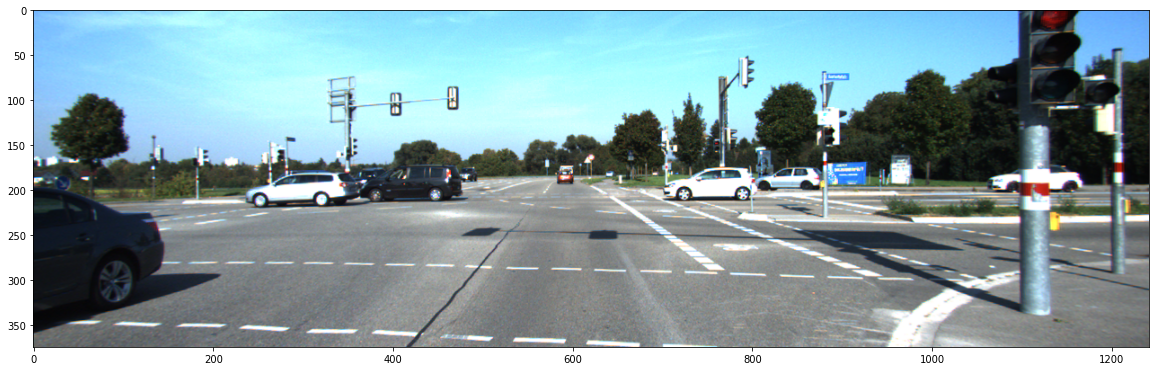

In [4]:
!wget -O kitti_test.png https://raw.githubusercontent.com/tugstugi/dl-colab-notebooks/master/resources/kitti_005064.png
img = cv2.imread('kitti_test.png')
imshow('', img)

Now, test the CenterNet on the above image:

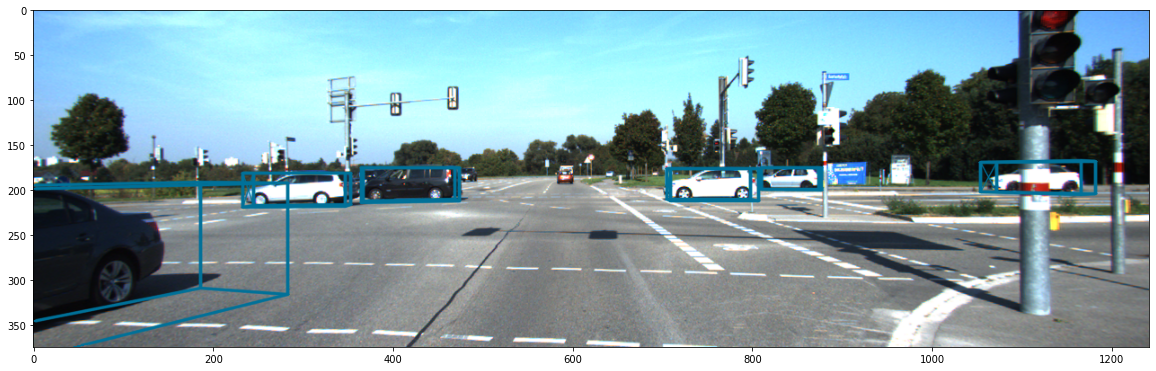

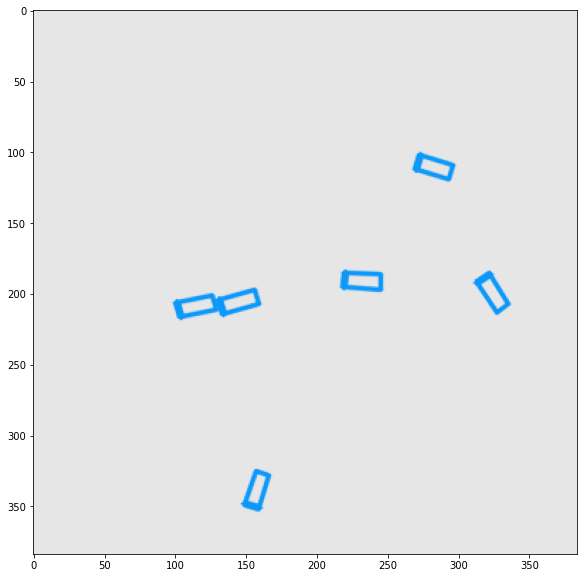

In [5]:
ret = detector.run(img)